# Davies-Bouldin Index: Evaluando la Calidad del Clustering

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs, make_circles
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score

# Configuración para gráficos
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

np.random.seed(42)
print("=== ANÁLISIS DE CLUSTERING USANDO DAVIES-BOULDIN INDEX ===\n")


=== ANÁLISIS DE CLUSTERING USANDO DAVIES-BOULDIN INDEX ===



In [26]:
def create_datasets():
    """Genera tres datasets con diferentes niveles de dificultad."""
    
    X1, y1 = make_blobs(
        n_samples=300, centers=4, cluster_std=1.0,
        center_box=(-10, 10), random_state=42
    )
    X2, y2 = make_blobs(
        n_samples=300, centers=4, cluster_std=2.5,
        center_box=(-5, 5), random_state=42
    )
    X3, y3 = make_circles(
        n_samples=300, noise=0.1, factor=0.3, random_state=42
    )
    
    return [
        (X1, y1, "Clusters bien separados"),
        (X2, y2, "Clusters solapados"),
        (X3, y3, "Clusters circulares")
    ]


In [28]:
def evaluate_clustering(X, true_labels, dataset_name):
    """Evalúa K-Means, Agglomerative y Gaussian Mixture usando DBI."""
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    algorithms = {
        'K-Means': lambda k: KMeans(n_clusters=k, random_state=42, n_init=10),
        'Hierarchical': lambda k: AgglomerativeClustering(n_clusters=k),
        'Gaussian Mixture': lambda k: GaussianMixture(n_components=k, random_state=42)
    }
    
    k_range = range(2, 8)
    results = []
    
    for alg_name, alg_func in algorithms.items():
        for k in k_range:
            model = alg_func(k)
            if hasattr(model, 'fit_predict'):
                labels = model.fit_predict(X_scaled)
            else:
                labels = model.fit(X_scaled).predict(X_scaled)
            
            dbi = davies_bouldin_score(X_scaled, labels)
            results.append({
                'Algorithm': alg_name,
                'k': k,
                'DBI': dbi,
                'Dataset': dataset_name
            })
    
    return pd.DataFrame(results)


In [16]:
def plot_results(results_list):
    """Crea visualizaciones globales de todos los experimentos."""
    
    all_results = pd.concat(results_list, ignore_index=True)
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Evaluación de Clustering con Davies-Bouldin Index', 
                 fontsize=16, fontweight='bold')

    # --- Gráfico 1: DBI vs k por dataset y algoritmo ---
    ax1 = axes[0, 0]
    for dataset in all_results['Dataset'].unique():
        subset = all_results[all_results['Dataset'] == dataset]
        for alg in subset['Algorithm'].unique():
            data = subset[subset['Algorithm'] == alg]
            ax1.plot(data['k'], data['DBI'], marker='o', label=f'{dataset[:15]}... - {alg}')
    ax1.set_xlabel('Número de Clusters (k)')
    ax1.set_ylabel('Davies-Bouldin Index')
    ax1.set_title('DBI vs Número de Clusters')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)

    # --- Gráfico 2: Distribución de DBI por algoritmo ---
    ax2 = axes[0, 1]
    sns.boxplot(data=all_results, x='Algorithm', y='DBI', ax=ax2)
    ax2.set_title('Distribución de DBI por Algoritmo')
    ax2.tick_params(axis='x', rotation=45)

    # --- Gráfico 3: Heatmap de DBI promedio ---
    ax3 = axes[1, 0]
    pivot = (all_results
             .groupby(['Dataset', 'Algorithm', 'k'])['DBI']
             .mean()
             .reset_index())
    heat_data = pivot.pivot_table(values='DBI', index=['Dataset', 'Algorithm'], columns='k')
    sns.heatmap(heat_data, annot=True, fmt='.2f', cmap='RdYlBu_r', ax=ax3)
    ax3.set_title('Heatmap de DBI (menor es mejor)')

    # --- Gráfico 4: Mejor k por dataset y algoritmo ---
    ax4 = axes[1, 1]
    best_k = all_results.loc[all_results.groupby(['Dataset', 'Algorithm'])['DBI'].idxmin()]
    sns.barplot(data=best_k, x='Dataset', y='k', hue='Algorithm', ax=ax4)
    ax4.set_title('Número Óptimo de Clusters (k)')
    ax4.tick_params(axis='x', rotation=45)
    ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()


In [22]:
def detailed_example():
    """Ejemplo paso a paso con desglose de cálculo del DBI."""
    print("=== EJEMPLO DETALLADO: DAVIES-BOULDIN INDEX ===\n")
    
    X, true_labels = make_blobs(
        n_samples=200, centers=3, cluster_std=1.5,
        center_box=(-8, 8), random_state=42
    )
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    print(f"Dataset generado con {X.shape[0]} muestras y {X.shape[1]} características.")
    print("Número real de clusters: 3\n")
    
    k_values = [2, 3, 4, 5]
    print("Evaluando diferentes valores de k:\n")
    
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X_scaled)
        dbi = davies_bouldin_score(X_scaled, labels)
        print(f"  k={k}: DBI = {dbi:.3f}")
        
        if k == 3:
            print("\n  Desglose para k=3:")
            centroids = kmeans.cluster_centers_
            for i in range(k):
                cluster_points = X_scaled[labels == i]
                s_i = np.mean([np.linalg.norm(point - centroids[i]) for point in cluster_points])
                print(f"    Cluster {i}: S({i}) = {s_i:.3f} (dispersión interna)")
            print(f"  DBI final: {dbi:.3f}")
    
    best_k = k_values[np.argmin([
        davies_bouldin_score(X_scaled, KMeans(n_clusters=k, random_state=42).fit_predict(X_scaled))
        for k in k_values
    ])]
    
    print(f"\nConclusión → Número óptimo de clusters según DBI: k={best_k} (valor real: 3)")


Iniciando análisis...

Evaluando: Clusters bien separados


C:\Users\ShePlay\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\ShePlay\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\ShePlay\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\ShePlay\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak o

Evaluando: Clusters solapados


C:\Users\ShePlay\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\ShePlay\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\ShePlay\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\ShePlay\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak o

Evaluando: Clusters circulares


C:\Users\ShePlay\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\ShePlay\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\ShePlay\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(



=== RESUMEN DE RESULTADOS ===
Clusters bien separa...: K-Means con k=4 (DBI=0.281)
Clusters circulares...: K-Means con k=7 (DBI=0.651)
Clusters solapados...: K-Means con k=3 (DBI=0.859)


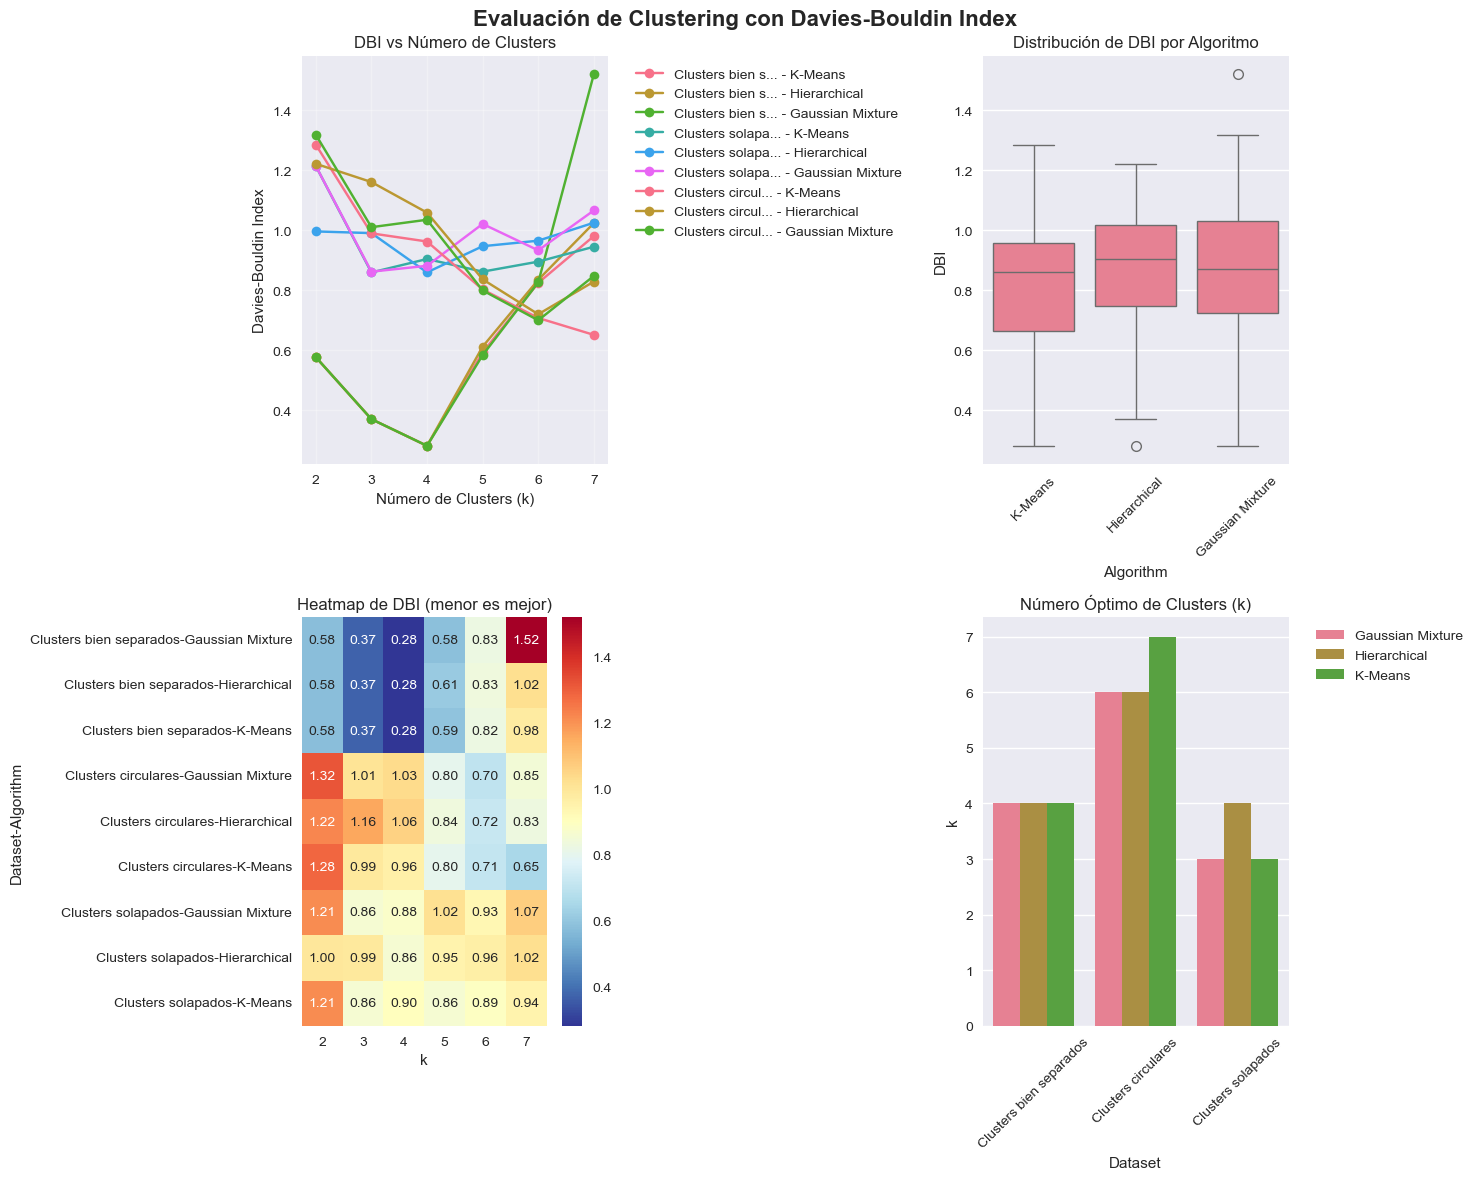


=== EJEMPLO DETALLADO: DAVIES-BOULDIN INDEX ===

Dataset generado con 200 muestras y 2 características.
Número real de clusters: 3

Evaluando diferentes valores de k:

  k=2: DBI = 0.549
  k=3: DBI = 0.405

  Desglose para k=3:
    Cluster 0: S(0) = 0.390 (dispersión interna)
    Cluster 1: S(1) = 0.355 (dispersión interna)
    Cluster 2: S(2) = 0.427 (dispersión interna)
  DBI final: 0.405
  k=4: DBI = 0.683
  k=5: DBI = 0.915

Conclusión → Número óptimo de clusters según DBI: k=3 (valor real: 3)


C:\Users\ShePlay\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\ShePlay\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\ShePlay\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\ShePlay\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak o

In [20]:
# Generar datasets y evaluar
datasets = create_datasets()
results_list = []

print("Iniciando análisis...\n")
for X, y, name in datasets:
    print(f"Evaluando: {name}")
    results = evaluate_clustering(X, y, name)
    results_list.append(results)

# Resumen general
all_results = pd.concat(results_list, ignore_index=True)
print("\n=== RESUMEN DE RESULTADOS ===")
best_configs = all_results.loc[all_results.groupby('Dataset')['DBI'].idxmin()]

for _, row in best_configs.iterrows():
    print(f"{row['Dataset'][:20]}...: {row['Algorithm']} con k={row['k']} (DBI={row['DBI']:.3f})")

# Graficar resultados comparativos
plot_results(results_list)

# Ejemplo educativo detallado
print("\n" + "="*60)
detailed_example()
